<a href="https://colab.research.google.com/github/Astro-Beam/ASTRO/blob/main/Neural%20Networks/Localized_Classification_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Necessary dependencies / libraries

In [4]:
#Run this block to import the necessary dependencies
#!pip install torch torchvision
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter

#Denoising Autoencoder (DAE)

##Create the training dataset

###Comments

Explaining the comments and the choices made in the code:
- `# Convert to PyTorch tensors` - A torch.tensor is a multi-dimensional matrix containing elements of a single data type. We convert the data into a PyTorch tensor in order to feed this data into PyTorch models, such as our autoencoder, and use it for forward passes, training, and evaluation.
- `torch.float32` - It means that each element in the tensor will be stored as a 32-bit floating point number (a common data type for numeric operations in neural networks).
It ensures that the data is in a format suitable for floating-point computations, which is critical for training neural networks in PyTorch since most deep learning operations work with floating point numbers.
- `# Batch size` - Batch size is a hyperparameter that defines the number of samples for the autoencoder to work through before updating internal model parameters

###Code

<ipython-input-5-83eaae018851>:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signals_tensor = torch.tensor(signals, dtype=torch.float32)


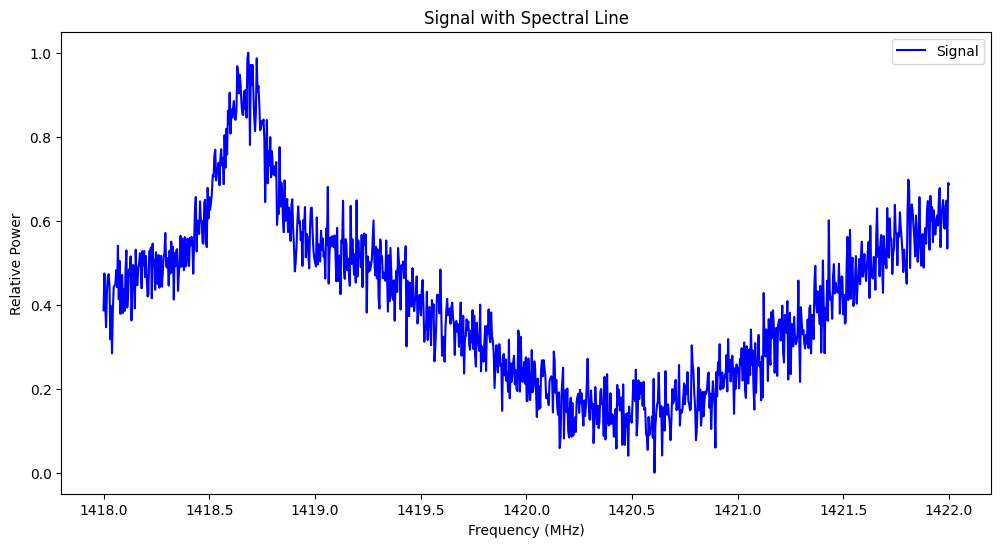

In [5]:
# Define a function to generate a background-only signal (without spectral line)
def generate_background_signal(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)
    # Random background signal generation
    signal = (np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range) +
              np.random.uniform(0.05, 0.5) * np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range))
    # Add random Gaussian noise
    signal += np.random.normal(0, np.random.uniform(0.1, 0.3), len(signal))
    # Normalize the signal
    signal += np.abs(np.min(signal))
    signal /= np.max(np.abs(signal))
    return signal

# Define a function to generate a signal with a spectral line
def generate_signal_with_spectral_line(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)
    # Add randomness to the background signal generation
    signal = (np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range) +
              np.random.uniform(0.05, 0.5) * np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range))
    # Add the spectral line at a random frequency
    signal += np.random.uniform(1, 3) * np.exp(-0.5 * ((freq_range - np.random.uniform(1418.5, 1421.5)) / 0.1)**2)
    # Add random Gaussian noise
    signal += np.random.normal(0, np.random.uniform(0.1, 0.3), len(signal))
    # Normalize the signal
    signal += np.abs(np.min(signal))
    signal /= np.max(np.abs(signal))
    return signal

# Signal parameters
n_samples = 1000  # Number of sample points in each signal
freq_range = np.linspace(1418, 1422, n_samples)  # Frequency range
n_signals = 3000  # Total number of signals to generate
signals_fraction = n_signals // 2 # Number of signals WITHOUT spectral lines

# Generate half signals with spectral lines and half without
signals = []
labels = []

# Generate background-only signals
for _ in range(signals_fraction):
    signals.append(generate_background_signal(n_samples))
    labels.append(0)  # Label for background-only

# Generate signals with spectral lines
for _ in range(n_signals - signals_fraction):
    signals.append(generate_signal_with_spectral_line(n_samples))
    labels.append(1)  # Label for signal with spectral line

# Convert to PyTorch tensors
signals_tensor = torch.tensor(signals, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Create a DataLoader for batching
dataset = TensorDataset(signals_tensor, labels_tensor)
batch_size = 64  # Batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot a sample signal
sample_signal = generate_signal_with_spectral_line(n_samples)
plt.figure(figsize=(12, 6))
plt.plot(freq_range, sample_signal, label='Signal', color='blue')
plt.title('Signal with Spectral Line')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative Power')
plt.legend()
plt.show()

##Define the DAE

###Comments

Comments:
- `nn.Module` is the base class for all neural networks in PyTorch.
- `ReLU (nn.ReLU())` - This is a popular activation function that introduces non-linearity into the model (Activation functions are essential in neural networks as they determine the output of a node given an input or set of inputs). It helps to handle complex data distributions and makes the model more powerful. The **Rectified Linear Unit** (ReLU) is one of the most widely used activation functions in deep learning. The ReLU function is defined as: **ReLU(x) = max(0, x)**. This means that if the input x is positive, the output will be x. If the input x is negative, the output will be 0.
- `nn.Linear(n_samples, 512)` - The first layer takes in the input (which has n_samples data points) and reduces it to 512 neurons.
- `nn.Linear(512, 128)` - This second layer further compresses the 512 neurons down to 128 neurons.
- `nn.Linear(128, 32)` - The final layer compresses the 128 neurons down to 32 neurons, which is the **latent space representation**. This is where the most significant compression occurs.
- `nn.Tanh()` -  [DEPRECATED]  We use the **tanh** activation function, so that our values are between -1 and 1.

- `nn.Sigmoid()` - The **sigmoid activation function** outputs values between 0 and 1. It introduces non-linearity and is particularly useful for making sure the output remains within a specific range.

###Code

In [6]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(n_samples, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        # Decoder with Tanh for negative values
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, n_samples),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the DAE model
dae = DenoisingAutoencoder()

# Print the model architecture
print(dae)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1000, bias=True)
    (3): Sigmoid()
  )
)


##Define the training loop

###Comments

We then have to define the **loss function** and the **optimizer** we will use in our autoencoder, in order to create the training loop.
 - For the **loss function** we use the **Mean Squared Error** function, a popular loss function used in regression tasks that measures the average squared differences between predicted and actual values.
 - For the **optimizer** we use the **ADAM optimizer**. Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm.

We have to consider the **number of epochs** for the best training of the autoencoder. Generally speaking, the number of epochs will change if the dataset is bigger.
 - The number of epochs should not be decided a-priori. We should run the training and monitor the training and validation losses over time and stop training when the validation loss reaches a plateau or starts increasing. This technique is called "**early stopping**" and is a good practice in machine learning.


###Code

Epoch [1/50], Loss: 0.0141
Epoch [2/50], Loss: 0.0136
Epoch [3/50], Loss: 0.0131
Epoch [4/50], Loss: 0.0102
Epoch [5/50], Loss: 0.0096
Epoch [6/50], Loss: 0.0086
Epoch [7/50], Loss: 0.0080
Epoch [8/50], Loss: 0.0064
Epoch [9/50], Loss: 0.0063
Epoch [10/50], Loss: 0.0059
Epoch [11/50], Loss: 0.0054
Epoch [12/50], Loss: 0.0052
Epoch [13/50], Loss: 0.0055
Epoch [14/50], Loss: 0.0055
Epoch [15/50], Loss: 0.0051
Epoch [16/50], Loss: 0.0051
Epoch [17/50], Loss: 0.0047
Epoch [18/50], Loss: 0.0054
Epoch [19/50], Loss: 0.0049
Epoch [20/50], Loss: 0.0045
Epoch [21/50], Loss: 0.0045
Epoch [22/50], Loss: 0.0043
Epoch [23/50], Loss: 0.0046
Epoch [24/50], Loss: 0.0043
Epoch [25/50], Loss: 0.0045
Epoch [26/50], Loss: 0.0046
Epoch [27/50], Loss: 0.0042
Epoch [28/50], Loss: 0.0044
Epoch [29/50], Loss: 0.0049
Epoch [30/50], Loss: 0.0042
Epoch [31/50], Loss: 0.0046
Epoch [32/50], Loss: 0.0042
Epoch [33/50], Loss: 0.0051
Epoch [34/50], Loss: 0.0043
Epoch [35/50], Loss: 0.0042
Epoch [36/50], Loss: 0.0043
E

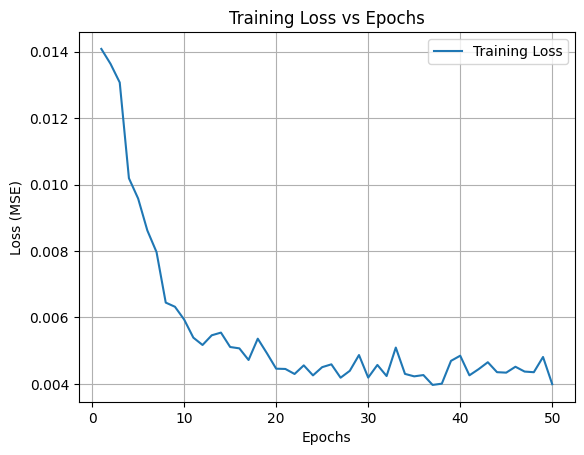

In [7]:
# Loss function (Mean Squared Error) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dae.parameters(), lr=0.001)

# Noise generation for corrupting the input
def add_noise(signal, noise_level=0.1):
    noise = torch.normal(0, noise_level, signal.shape)
    noisy_signal = signal + noise
    return noisy_signal

# Number of epochs
n_epochs = 50

# List to store the loss values for each epoch
loss_values = []

for epoch in range(n_epochs):
    for data in dataloader:
        clean_signals = data[0]  # Get the clean signals batch

        # Corrupt the clean signals with noise
        noisy_signals = add_noise(clean_signals)

        # Forward pass: autoencoder's prediction from noisy signals
        reconstructed_signals = dae(noisy_signals)

        # Compute the loss (reconstruction error) between the original clean signal and the reconstructed signal
        loss = criterion(reconstructed_signals, clean_signals) # Using clean_signals yields much lower loss

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Store the loss for each epoch
    loss_values.append(loss.item())

    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Plot the loss versus epochs
plt.plot(range(1, n_epochs + 1), loss_values, label='Training Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.show()

##Autoencoder testing and results visualization

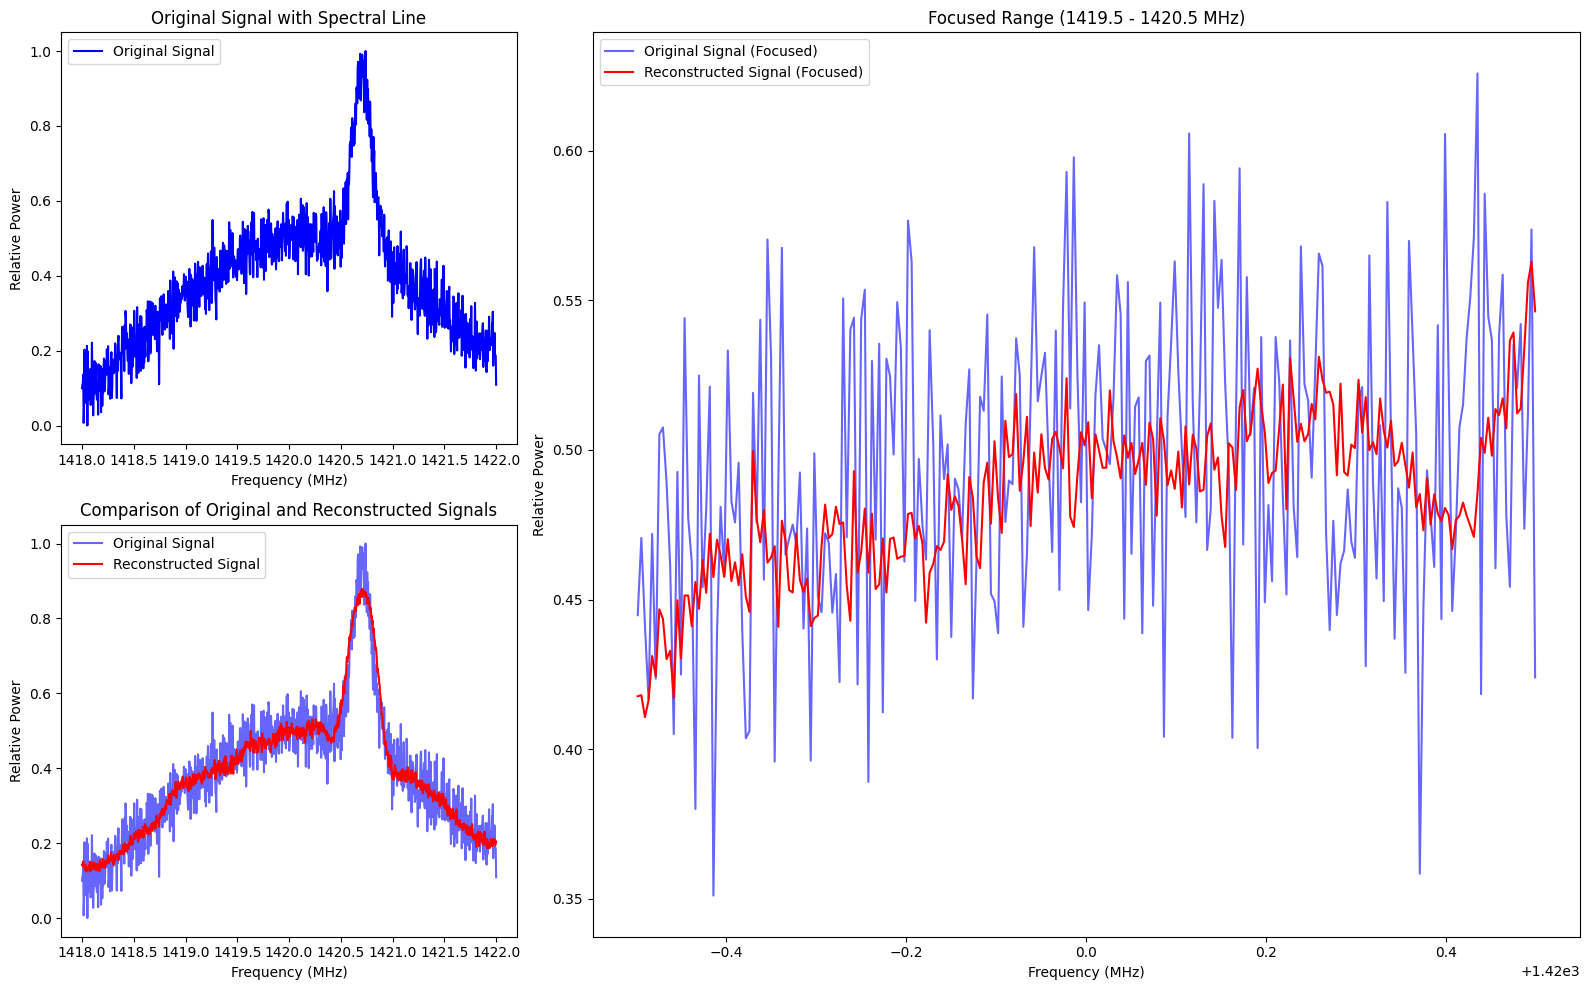

In [8]:
# Test the autoencoder with a sample signal
sample_signal = generate_signal_with_spectral_line(n_samples)
sample_signal_tensor = torch.tensor(sample_signal, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Pass the signal through the autoencoder
with torch.no_grad():
    reconstructed_signal = dae(sample_signal_tensor).squeeze(0).numpy()

# Define the focus range for a specific frequency range
focus_range_mask = (freq_range >= 1419.5) & (freq_range <= 1420.5)
focused_freq_range = freq_range[focus_range_mask]
focused_clean_signal = sample_signal[focus_range_mask]
focused_reconstructed_signal = reconstructed_signal[focus_range_mask]

# Create the subplots in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# Upper left plot: Original Signal with Spectral Line
axs[0, 0].plot(freq_range, sample_signal, label='Original Signal', color='blue')
axs[0, 0].set_title('Original Signal with Spectral Line')
axs[0, 0].set_xlabel('Frequency (MHz)')
axs[0, 0].set_ylabel('Relative Power')
axs[0, 0].legend()

# Lower left plot: Comparison of Noisy and Reconstructed Signal
axs[1, 0].plot(freq_range, sample_signal, label='Original Signal', color='blue', alpha=0.6)  # Plot the original signal
axs[1, 0].plot(freq_range, reconstructed_signal, label='Reconstructed Signal', color='red')
axs[1, 0].set_title('Comparison of Original and Reconstructed Signals')
axs[1, 0].set_xlabel('Frequency (MHz)')
axs[1, 0].set_ylabel('Relative Power')
axs[1, 0].legend()

# Focused plot in the middle and right of the grid (spanning both rows)
ax_focus = plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=2)
ax_focus.plot(focused_freq_range, focused_clean_signal, label='Original Signal (Focused)', color='blue', alpha=0.6)
ax_focus.plot(focused_freq_range, focused_reconstructed_signal, label='Reconstructed Signal (Focused)', color='red')
ax_focus.set_title('Focused Range (1419.5 - 1420.5 MHz)')
ax_focus.set_xlabel('Frequency (MHz)')
ax_focus.set_ylabel('Relative Power')
ax_focus.legend()

# Hide unused subplot space
axs[0, 1].axis('off')
axs[0, 2].axis('off')
axs[1, 1].axis('off')
axs[1, 2].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

#Localized Classification Neural Network (LCNN)

##Traning Dataset generation:

In [ ]:
# Generate training dataset with regions
def generate_training_data(n_samples, n_regions, region_size):
    signals, labels = [], []
    for _ in range(n_regions):
        if np.random.rand() > 0.5:  # Region with spectral line
            signal = generate_signal_with_spectral_line(n_samples)
            peaks, _ = find_peaks(signal, height=0.8, width=50)
            if peaks.size > 0:
                peak_idx = np.random.choice(peaks)
                start = max(0, peak_idx - region_size // 2)
                end = min(n_samples, peak_idx + region_size // 2)
                region = signal[start:end]
                region = np.pad(region, (0, region_size - len(region)), mode='constant')
                signals.append(region)
                labels.append(1)
        else:  # Region without spectral line
            signal = generate_background_signal(n_samples)
            start = np.random.randint(0, n_samples - region_size)
            end = start + region_size
            signals.append(signal[start:end])
            labels.append(0)
    signals = np.array(signals)
    labels = np.array(labels)
    return signals, labels

## Peak Finding Function Testing

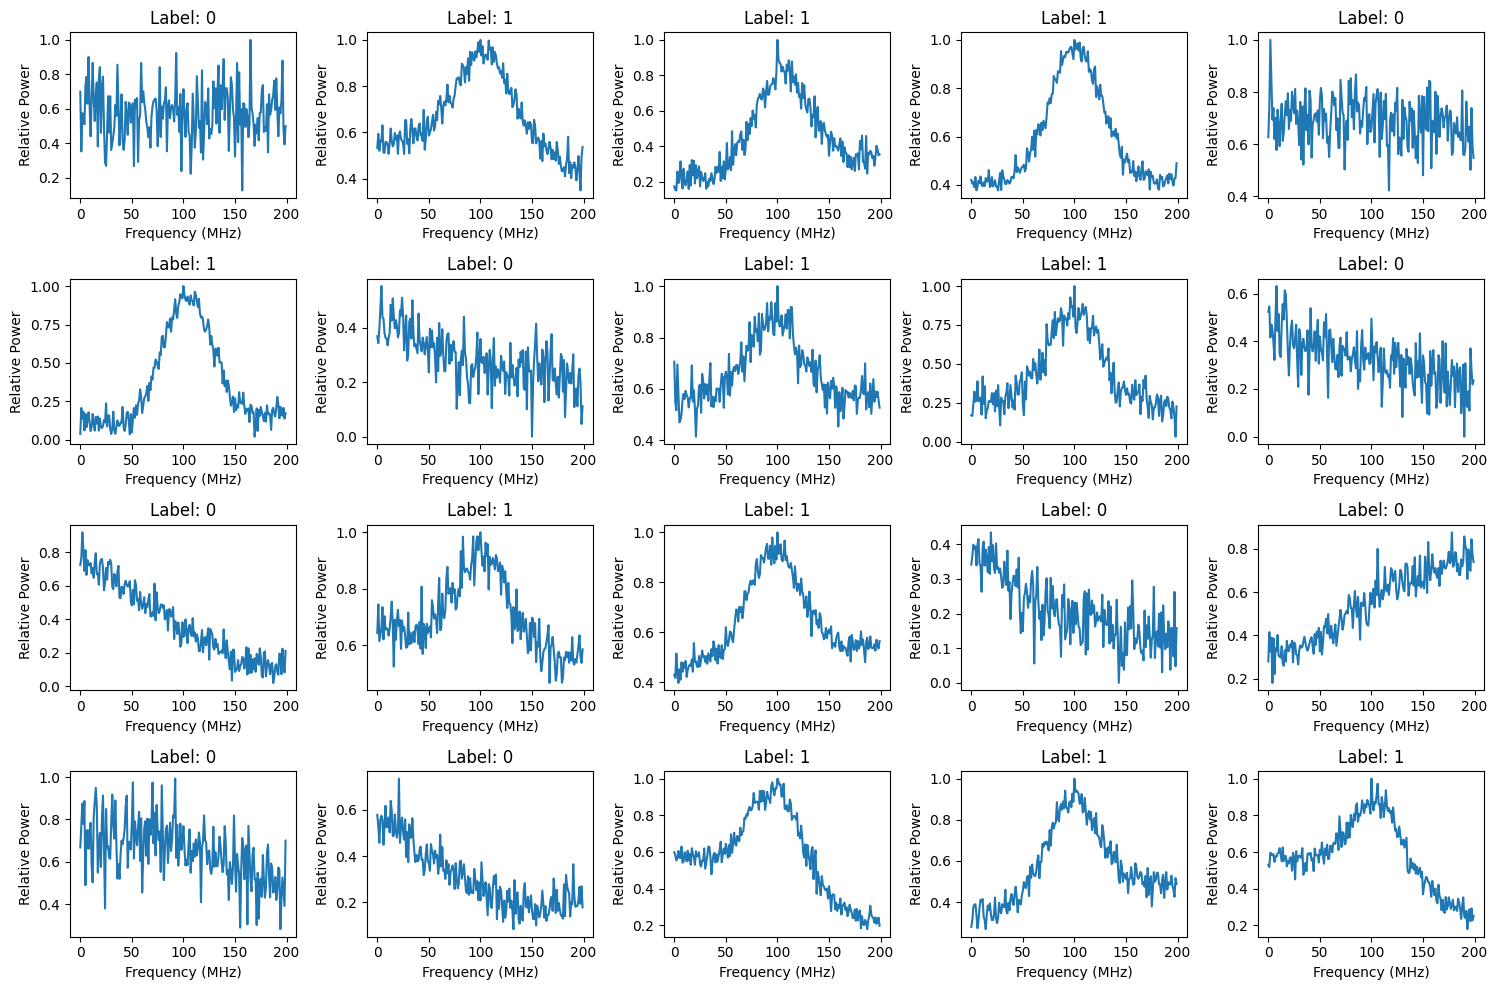

In [ ]:
# Parameters
n_samples = 1000
region_size = 200
n_regions = 5000

# Pick sample signals from training data
signals, labels = generate_training_data(n_samples, n_regions, region_size)

#Plot 20 sample signals in a figure, along with their respective label
fig, axs = plt.subplots(4, 5, figsize=(15, 10))
for i in range(20):
    axs[i // 5, i % 5].plot(signals[i])
    axs[i // 5, i % 5].set_title(f"Label: {labels[i]}")
    axs[i // 5, i % 5].set_xlabel('Frequency (MHz)')
    axs[i // 5, i % 5].set_ylabel('Relative Power')
plt.tight_layout()
plt.show()


## Define the LCNN

In [ ]:
# Neural network for spectral line classification
class SpectralLineClassifier(nn.Module):
    def __init__(self, region_size):
        super(SpectralLineClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

        # Calculate the output size after convolutions and pooling
        test_input = torch.zeros(1, 1, region_size)  # A mock input tensor
        out = self.pool(self.relu(self.conv2(self.relu(self.conv1(test_input)))))
        flattened_size = out.view(-1).size(0)

        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.sigmoid(self.fc2(x))

print(SpectralLineClassifier)

# Parameters
n_samples = 1000
region_size = 200
n_regions = 5000
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<class '__main__.SpectralLineClassifier'>


## Define the training loop

In [ ]:
# Training the classifier
def train_classifier(classifier, train_loader, device, epochs=100, lr=0.0001, patience=5):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(classifier.parameters(), lr=lr)

    best_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        classifier.train()
        epoch_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for signals_batch, labels_batch in train_loader:
            signals_batch = signals_batch.unsqueeze(1).to(device)
            labels_batch = labels_batch.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = classifier(signals_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate accuracy for this batch
            predictions = (outputs > 0.5).float()
            correct_predictions += (predictions == labels_batch).sum().item()
            total_predictions += labels_batch.size(0)

        # Calculate average loss and accuracy for the epoch
        epoch_accuracy = correct_predictions / total_predictions
        epoch_loss = epoch_loss / len(train_loader)

        # Early stopping logic
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Generate training data
signals, labels = generate_training_data(n_samples, n_regions, region_size)
train_dataset = TensorDataset(torch.tensor(signals, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize and train classifier
classifier = SpectralLineClassifier(region_size).to(device)
train_classifier(classifier, train_loader, device)

Epoch [1/100], Loss: 0.6144, Accuracy: 0.7303
Epoch [2/100], Loss: 0.3931, Accuracy: 0.9109
Epoch [3/100], Loss: 0.2438, Accuracy: 0.9163
Epoch [4/100], Loss: 0.1963, Accuracy: 0.9190
Epoch [5/100], Loss: 0.1755, Accuracy: 0.9181
Epoch [6/100], Loss: 0.1689, Accuracy: 0.9193
Epoch [7/100], Loss: 0.1640, Accuracy: 0.9226
Epoch [8/100], Loss: 0.1601, Accuracy: 0.9199
Epoch [9/100], Loss: 0.1531, Accuracy: 0.9258
Epoch [10/100], Loss: 0.1540, Accuracy: 0.9235
Epoch [11/100], Loss: 0.1522, Accuracy: 0.9235
Epoch [12/100], Loss: 0.1510, Accuracy: 0.9283
Epoch [13/100], Loss: 0.1452, Accuracy: 0.9287
Epoch [14/100], Loss: 0.1470, Accuracy: 0.9289
Epoch [15/100], Loss: 0.1455, Accuracy: 0.9276
Epoch [16/100], Loss: 0.1418, Accuracy: 0.9251
Epoch [17/100], Loss: 0.1399, Accuracy: 0.9316
Epoch [18/100], Loss: 0.1419, Accuracy: 0.9289
Epoch [19/100], Loss: 0.1401, Accuracy: 0.9271
Epoch [20/100], Loss: 0.1388, Accuracy: 0.9291
Epoch [21/100], Loss: 0.1393, Accuracy: 0.9276
Epoch [22/100], Loss: 

##Test the LCNN

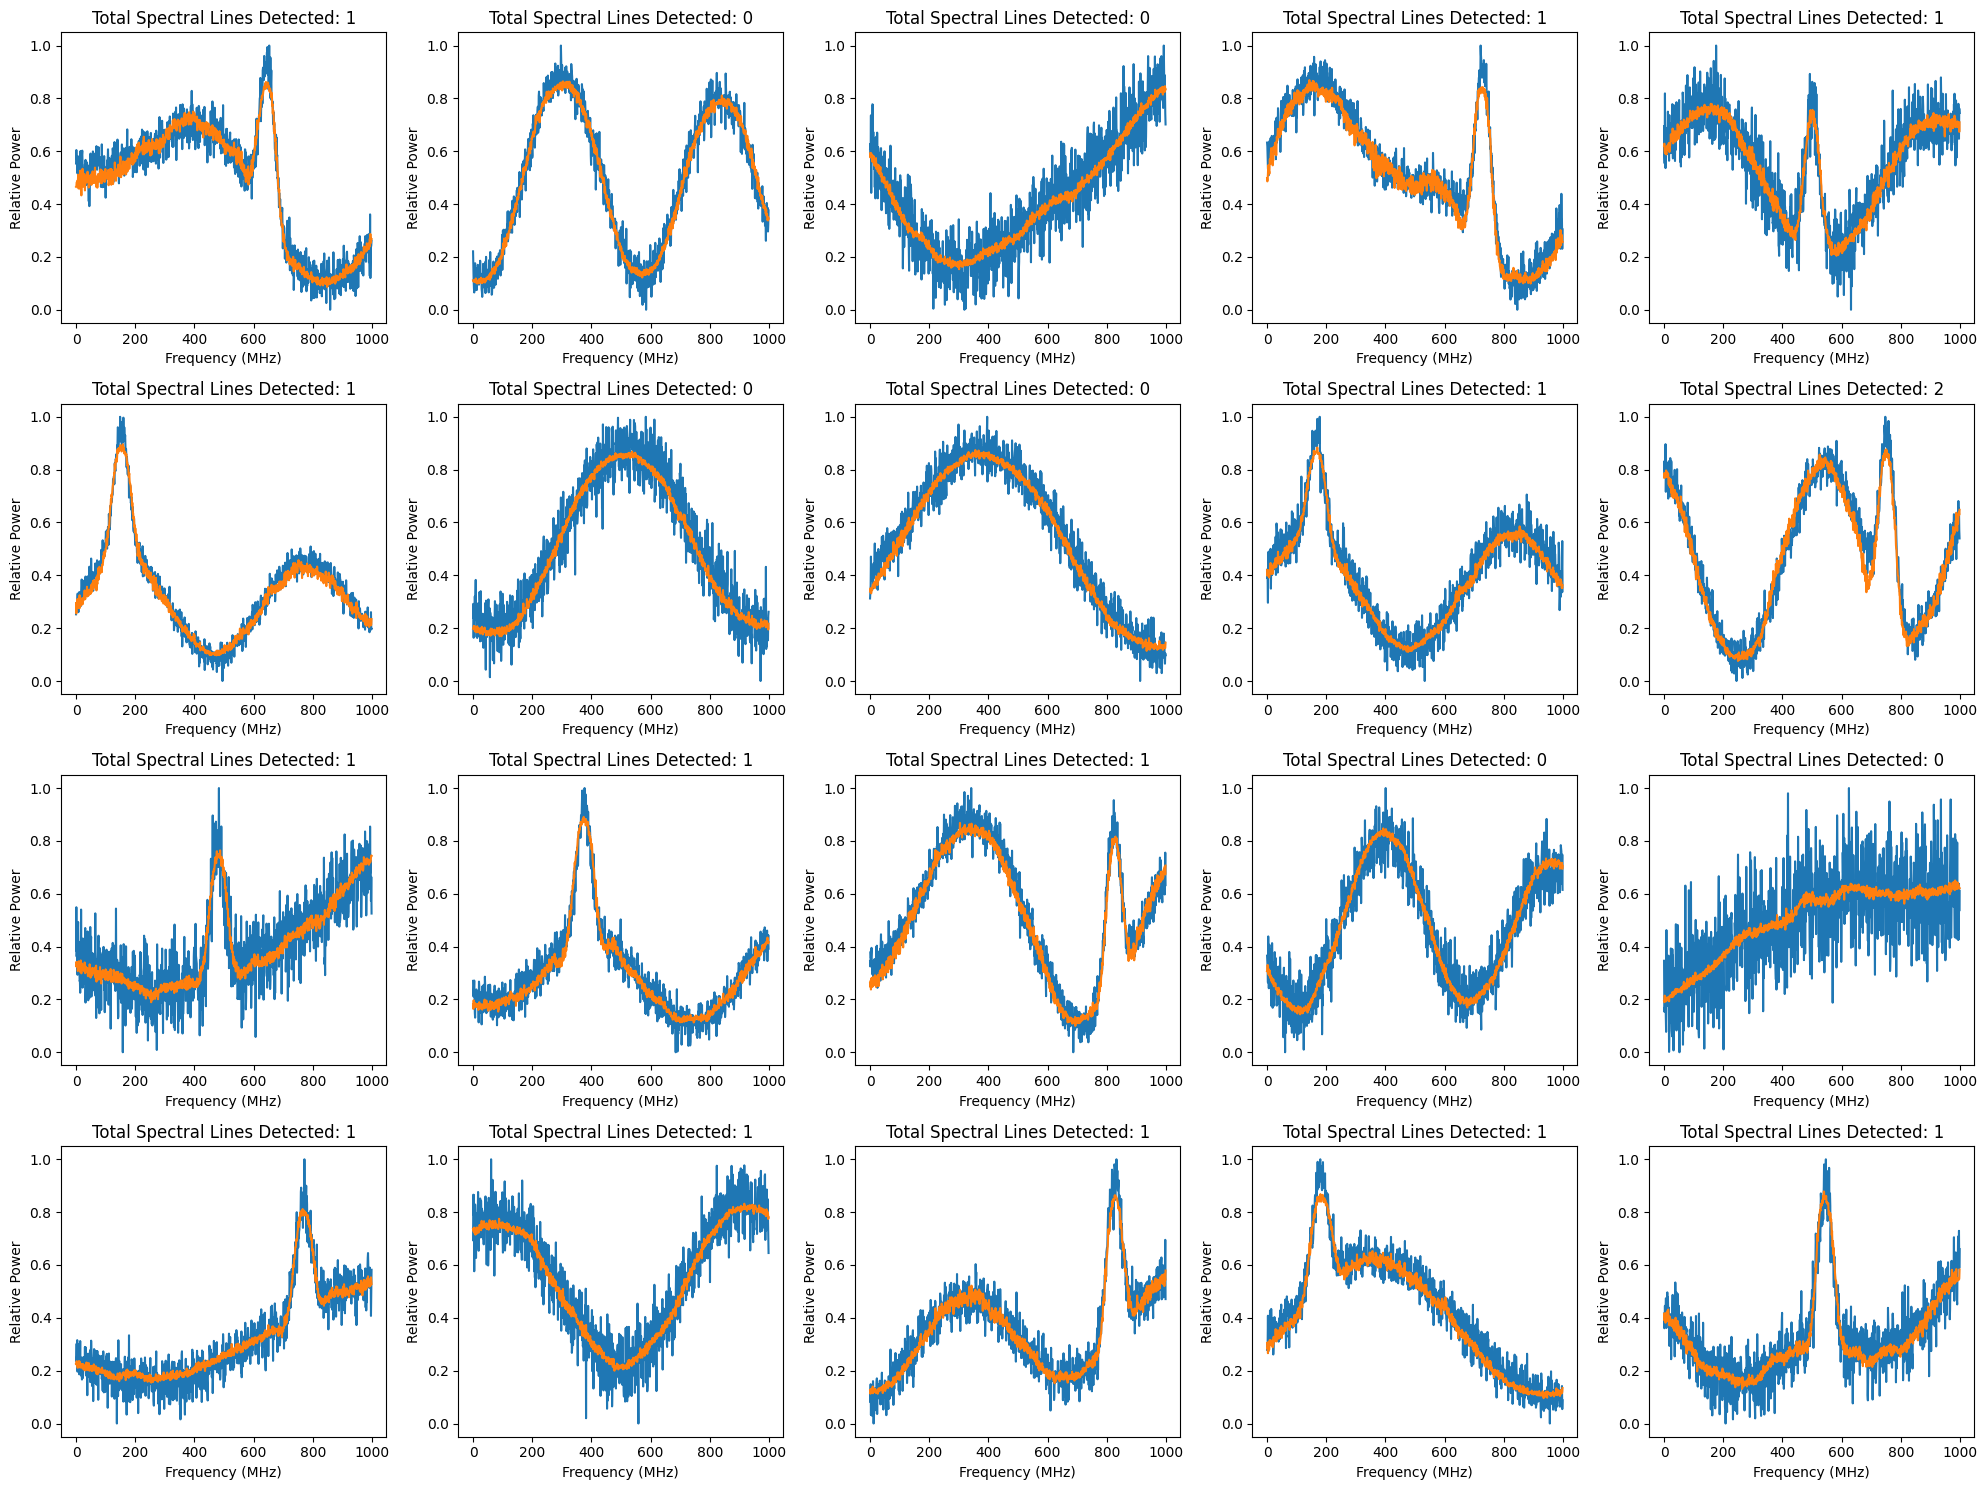

In [ ]:
def classify_signal(signal, dae, classifier, region_size, device):
    # Preprocess the signal with the DAE
    dae.eval()
    signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        reconstructed_signal = dae(signal_tensor).cpu().squeeze().numpy()

    # Find peaks in the reconstructed signal
    peaks, _ = find_peaks(reconstructed_signal, width=30)

    # Classify each region around a peak
    total_spectral_lines = 0
    for peak_idx in peaks:
        start = max(0, peak_idx - region_size // 2)
        end = min(len(signal), peak_idx + region_size // 2)
        region = reconstructed_signal[start:end]
        region = np.pad(region, (0, region_size - len(region)), mode='constant')
        region_tensor = torch.tensor(region, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        classifier.eval()
        with torch.no_grad():
            prediction = classifier(region_tensor)
            if prediction.item() > 0.75:
                total_spectral_lines += 1

    return total_spectral_lines, reconstructed_signal, peaks

# Smoothing functions
def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

def smooth_signal(signal, method="moving_average", **kwargs):
    if method == "moving_average":
        return moving_average(signal, kwargs.get("window_size", 5))
    elif method == "savitzky_golay":
        return savgol_filter(signal, kwargs.get("window_length", 7), kwargs.get("polyorder", 3))
    else:
        raise ValueError("Unsupported smoothing method. Use 'moving_average' or 'savitzky_golay'.")

# Test the pipeline
# Generate and plot 20 sample signals
fig, axs = plt.subplots(4, 5, figsize=(20, 15))
for i in range(20):
    if np.random.rand() > 0.5:
        test_signal = generate_signal_with_spectral_line(n_samples)
    else:
        test_signal = generate_background_signal(n_samples)

    smoothed_signal = smooth_signal(test_signal, method="moving_average", window_length=11, polyorder=2)
    total_lines, reconstructed_signal, peaks = classify_signal(smoothed_signal, dae, classifier, region_size, device)

    axs[i // 5, i % 5].plot(test_signal, label='Original Signal')
    axs[i // 5, i % 5].plot(reconstructed_signal, label='Reconstructed Signal')
    axs[i // 5, i % 5].set_title(f"Total Spectral Lines Detected: {total_lines}")
    axs[i // 5, i % 5].set_xlabel('Frequency (MHz)')
    axs[i // 5, i % 5].set_ylabel('Relative Power')

plt.tight_layout()
plt.show()

#Multiple Spectral Line Classification Neural Network (MSLCNN)

##Signal generation functions

In [10]:
# Function to generate background signal
def generate_background_signal(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)
    signal = (
        np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range) +
        np.random.uniform(0.05, 0.5) * np.sin(2 * np.pi * np.random.uniform(0.05, 0.5) * freq_range)
    )
    signal += np.random.normal(0, np.random.uniform(0.1, 0.3), len(signal))
    signal += np.abs(np.min(signal))
    signal /= np.max(np.abs(signal))
    return signal

# Function to add a single spectral line
def add_spectral_line(signal, freq_range, min_freq, max_freq):
    peak_position = np.random.uniform(min_freq, max_freq)
    amplitude = np.random.uniform(0.7, 1.2)
    spectral_line = amplitude * np.exp(-0.5 * ((freq_range - peak_position) / 0.1) ** 2)
    return signal + spectral_line

# Function to add two spectral lines
def add_two_spectral_lines(signal, freq_range, freq_ranges):
    line1_position = np.random.uniform(freq_ranges[0][0], freq_ranges[0][1])
    line2_position = np.random.uniform(freq_ranges[1][0], freq_ranges[1][1])
    amplitude1 = np.random.uniform(0.7, 1.2)
    amplitude2 = np.random.uniform(0.7, 1.2)

    spectral_line1 = amplitude1 * np.exp(-0.5 * ((freq_range - line1_position) / 0.1) ** 2)
    spectral_line2 = amplitude2 * np.exp(-0.5 * ((freq_range - line2_position) / 0.1) ** 2)
    return signal + spectral_line1 + spectral_line2

##Dataset generation

Total number of signals: 4998
Signals shape: torch.Size([3000, 1000])
Labels shape: torch.Size([3000])


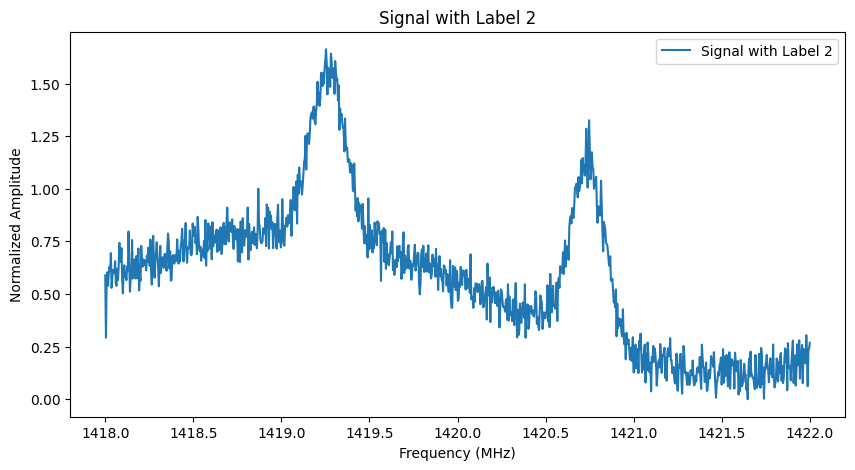

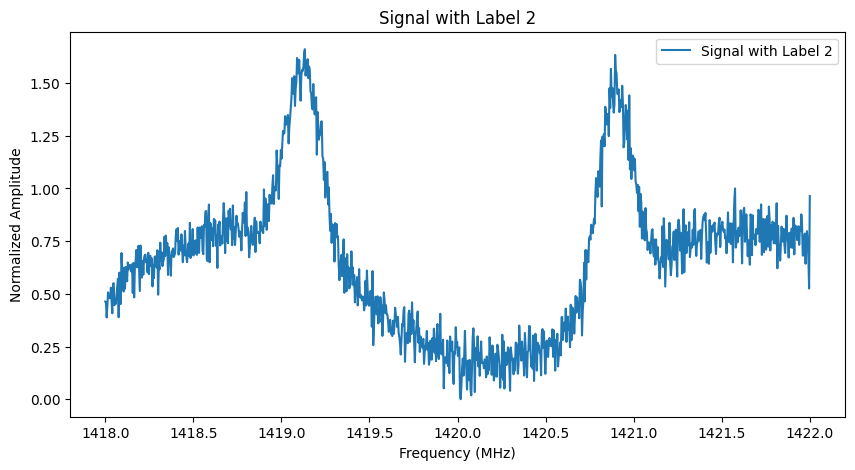

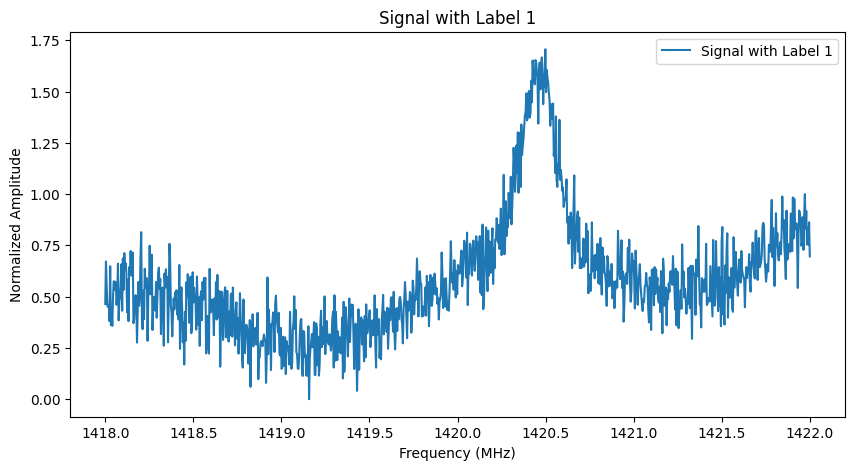

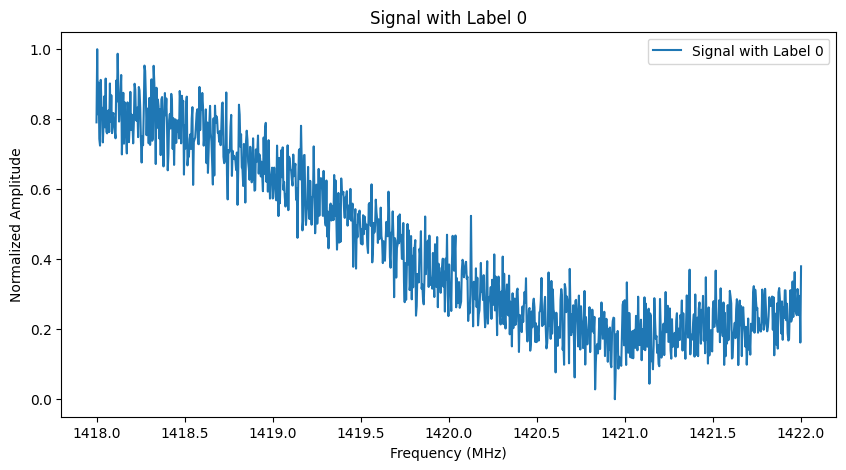

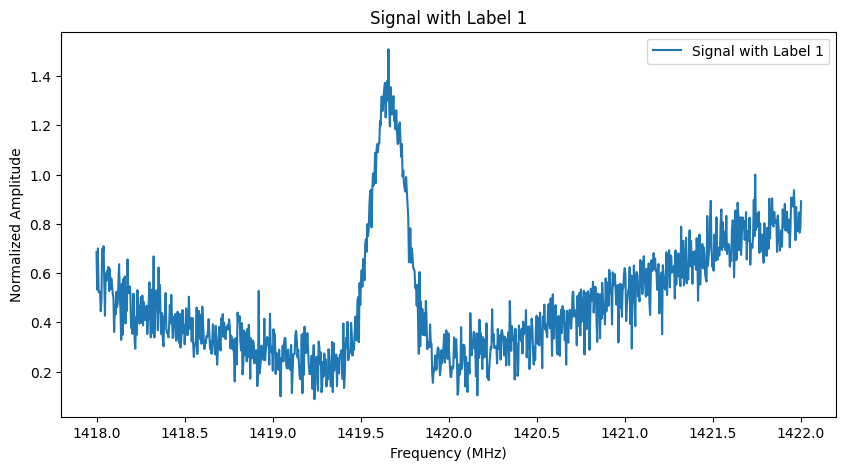

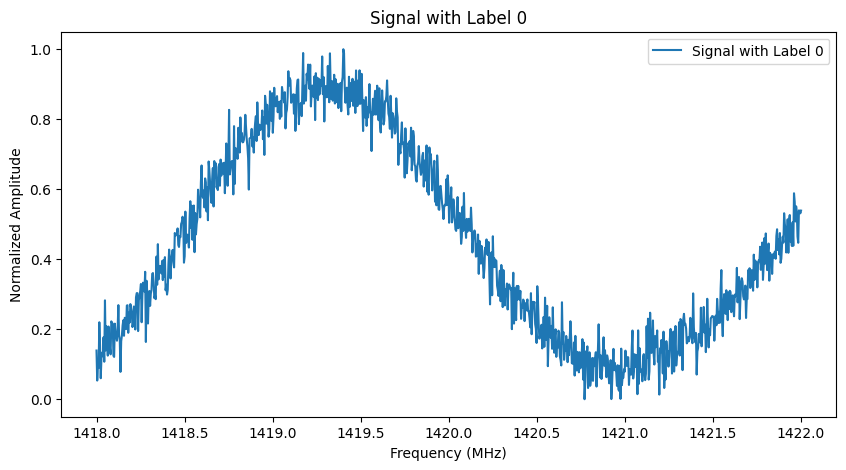

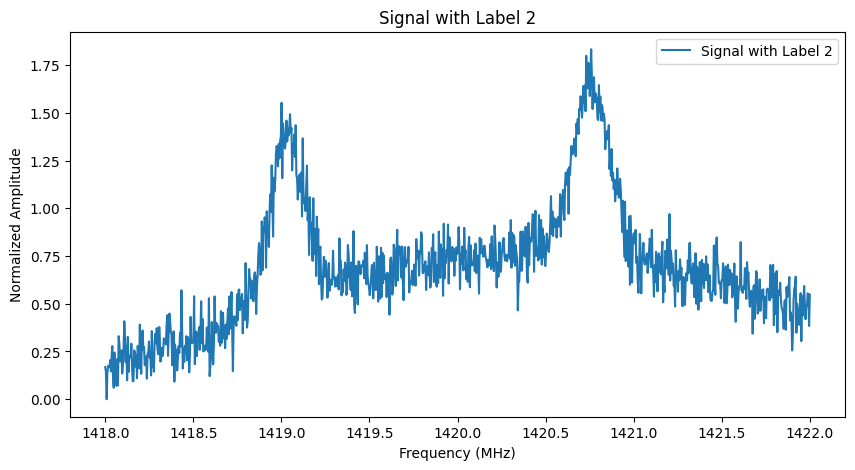

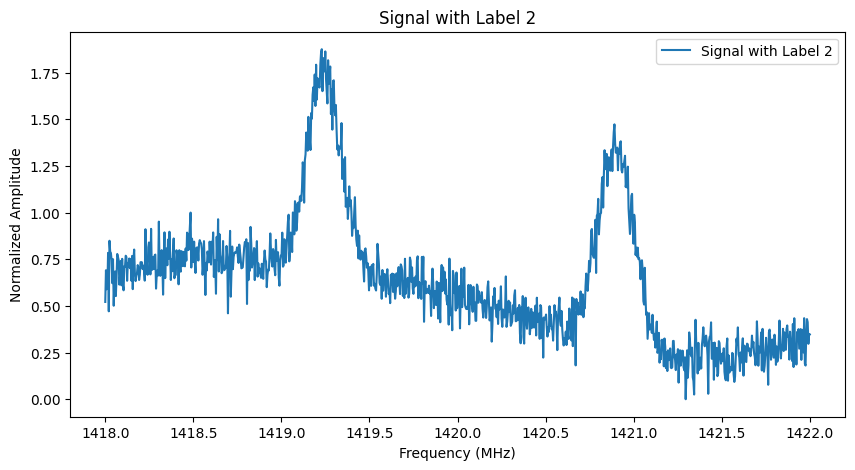

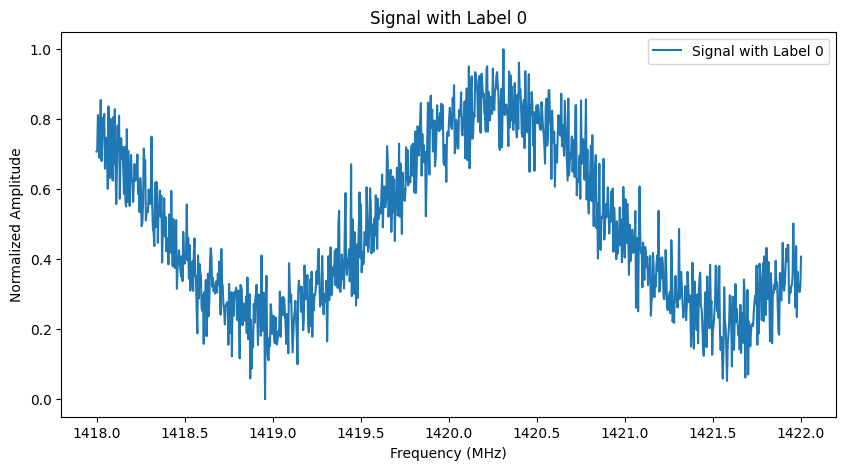

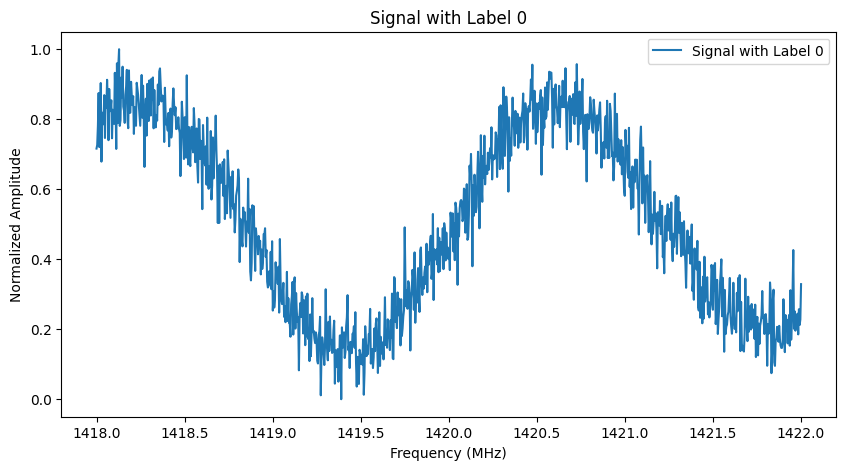

In [11]:
# Dataset generation function
def generate_dataset(n_samples, n_signals, freq_range):
    signals = []
    labels = []  # 0 for background, 1 for single line, 2 for two lines

    # Generate background signals
    for _ in range(n_signals // 3):
        signal = generate_background_signal(n_samples)
        signals.append(signal)
        labels.append(0)

    # Generate signals with a single spectral line
    for _ in range(n_signals // 3):
        signal = generate_background_signal(n_samples)
        signal = add_spectral_line(signal, freq_range, 1419.5, 1420.5)
        signals.append(signal)
        labels.append(1)

    # Generate signals with two spectral lines
    for _ in range(n_signals // 3):
        signal = generate_background_signal(n_samples)
        signal = add_two_spectral_lines(signal, freq_range, [(1419.0, 1419.5), (1420.5, 1421.0)])
        signals.append(signal)
        labels.append(2)

    # Shuffle dataset
    combined = list(zip(signals, labels))
    random.shuffle(combined)
    signals, labels = zip(*combined)

    return np.array(signals), np.array(labels)


# Usage
n_samples = 1000
n_signals = 5000
freq_range = np.linspace(1418, 1422, n_samples)

# Generate the dataset
signals, labels = generate_dataset(n_samples, n_signals, freq_range)

# Print dataset statistics
print(f"Total number of signals: {len(signals)}")
print(f"Signals shape: {signals_tensor.shape}")
print(f"Labels shape: {labels_tensor.shape}")

# Visualize random signals
for _ in range(10):
    idx = random.randint(0, len(signals) - 1)
    plt.figure(figsize=(10, 5))
    plt.plot(freq_range, signals[idx], label=f"Signal with Label {labels[idx]}")
    plt.title(f"Signal with Label {labels[idx]}")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.show()


batch_size = 64
# Split dataset into training and validation
val_split = int(0.8 * len(signals))
train_signals, val_signals = signals[:val_split], signals[val_split:]
train_labels, val_labels = labels[:val_split], labels[val_split:]

# Prepare DataLoader for training and validation
train_signals_tensor = torch.tensor(train_signals, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_signals_tensor = torch.tensor(val_signals, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_signals_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_signals_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

##Neural network structure

In [12]:
class SpectralLineClassifier(nn.Module):
    def __init__(self, input_size):
        super(SpectralLineClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear((input_size // 2) * 32, 64) # Maybe needs adjustment
        self.fc2 = nn.Linear(64, 3)  # 3 classes (0, 1, 2 spectral lines)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)  # Softmax output for 3 classes (because we have either 0, 1 or 2 spectral lines)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Training functions

In [13]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training function with early stopping and loss visualization
def train_model(model, train_loader, val_loader, device, epochs=50, lr=0.001, patience=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=patience)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for signals_batch, labels_batch in train_loader:
            signals_batch = signals_batch.unsqueeze(1).to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(signals_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for signals_batch, labels_batch in val_loader:
                signals_batch = signals_batch.unsqueeze(1).to(device)
                labels_batch = labels_batch.to(device)
                outputs = model(signals_batch)
                loss = criterion(outputs, labels_batch)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        # Early stopping check
        early_stopping(val_losses[-1])
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

###[Experimental] Code to preprocess the training/validation dataset using the DAE

Total number of signals: 4998
Signals shape: torch.Size([4998, 1000])
Labels shape: torch.Size([4998])


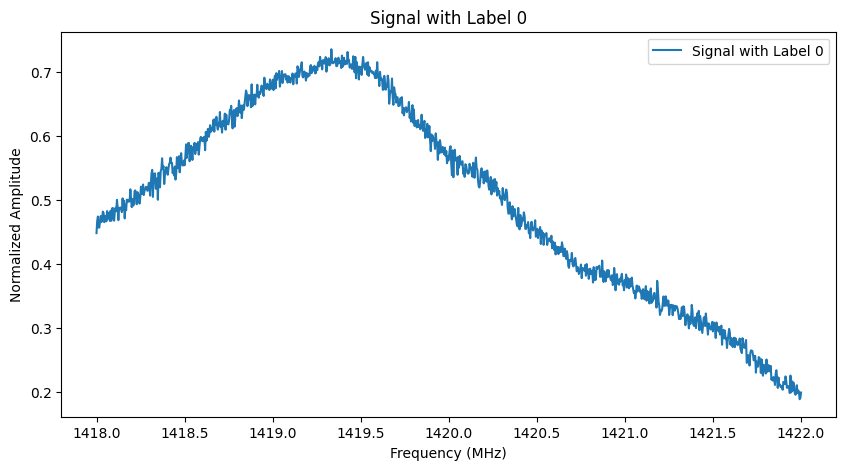

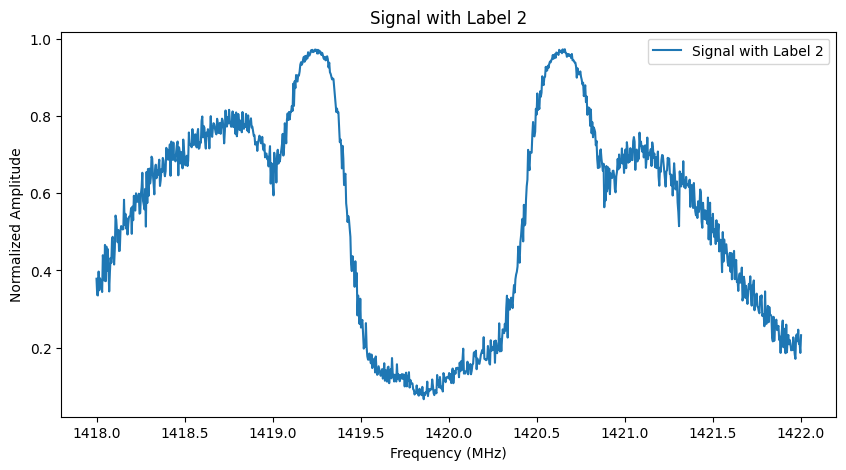

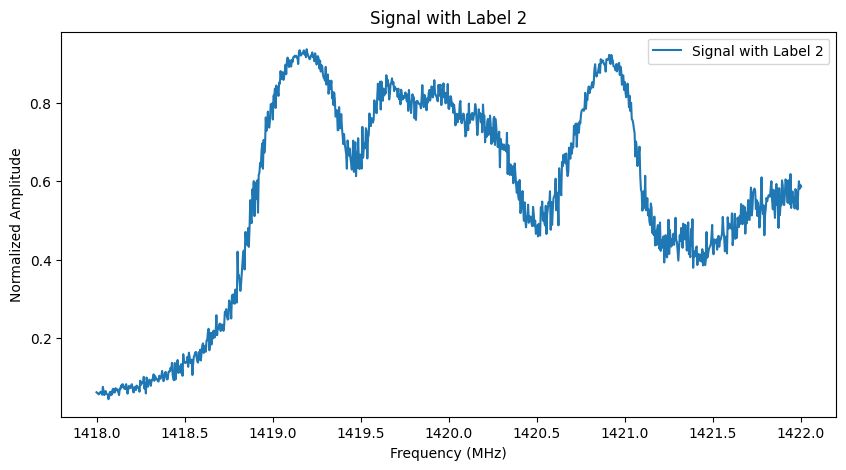

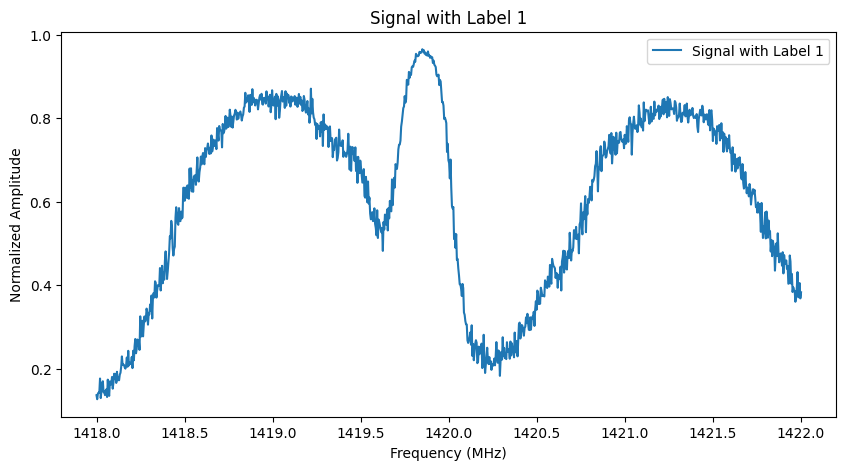

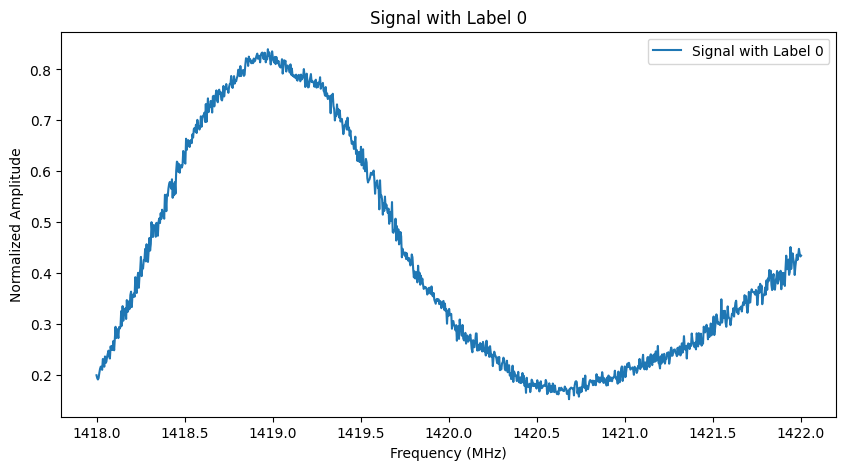

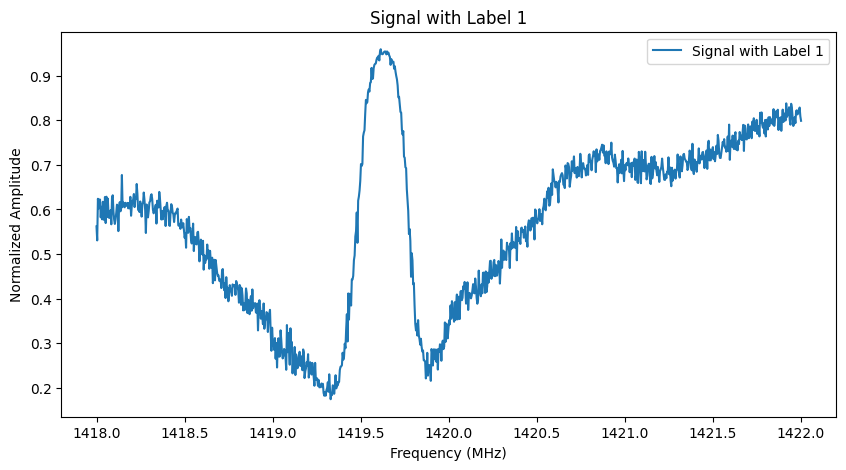

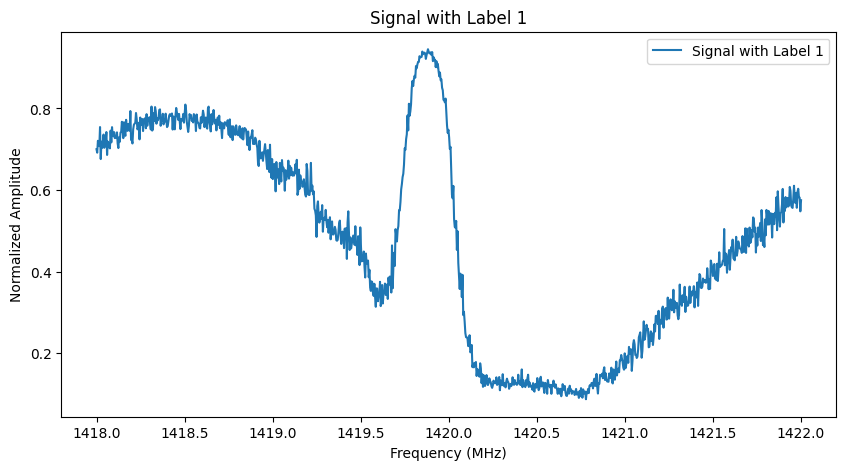

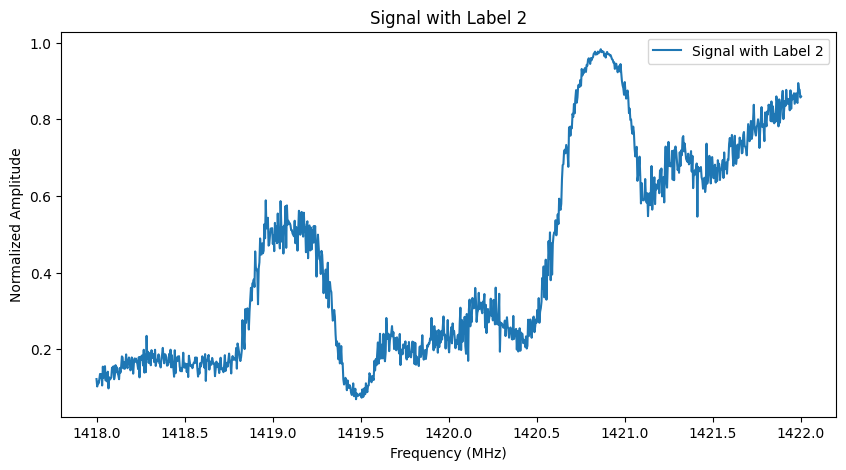

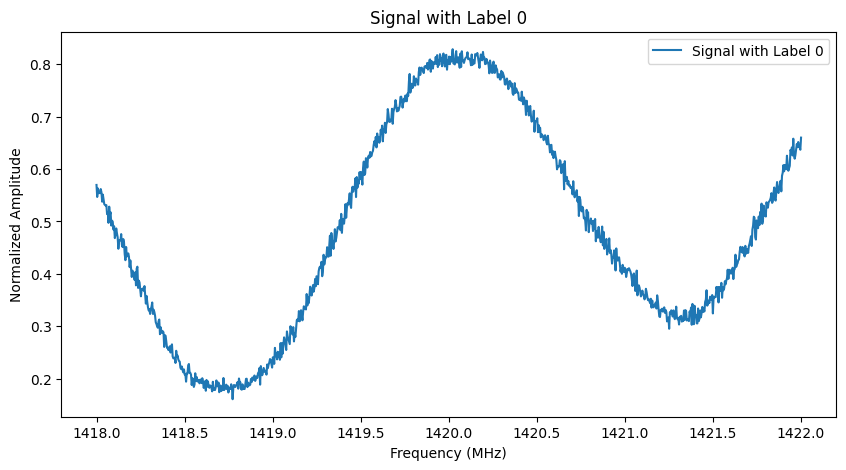

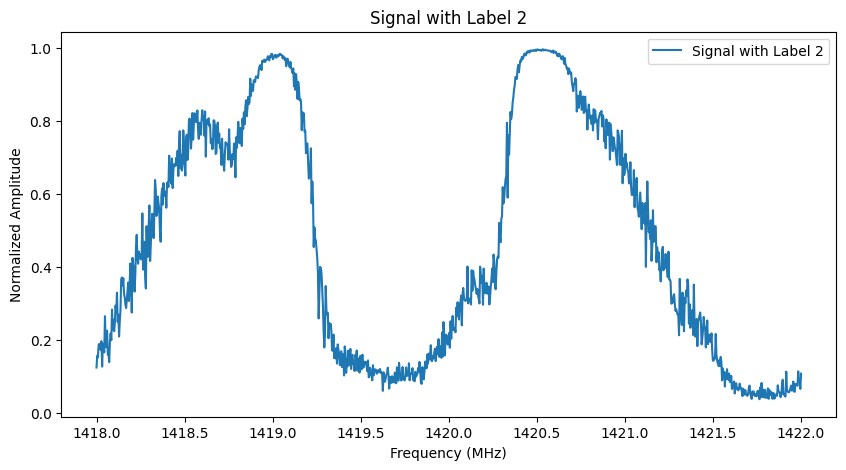

In [ ]:
# Dataset generation function with DAE integration
def generate_dataset_with_dae(n_samples, n_signals, freq_range, dae):
    signals = []
    labels = []  # 0 for background, 1 for single line, 2 for two lines

    # Ensure the DAE is in evaluation mode
    dae.eval()

    # Helper function to process signal through the DAE
    def process_signal(signal):
        signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            reconstructed_signal = dae(signal_tensor).squeeze(0).numpy()  # Remove batch dimension
        return reconstructed_signal

    # Generate background signals
    for _ in range(n_signals // 3):
        signal = generate_background_signal(n_samples)
        signal = process_signal(signal)
        signals.append(signal)
        labels.append(0)

    # Generate signals with a single spectral line
    for _ in range(n_signals // 3):
        signal = generate_background_signal(n_samples)
        signal = add_spectral_line(signal, freq_range, 1419.5, 1420.5)
        signal = process_signal(signal)
        signals.append(signal)
        labels.append(1)

    # Generate signals with two spectral lines
    for _ in range(n_signals // 3):
        signal = generate_background_signal(n_samples)
        signal = add_two_spectral_lines(signal, freq_range, [(1419.0, 1419.5), (1420.5, 1421.0)])
        signal = process_signal(signal)
        signals.append(signal)
        labels.append(2)

    # Shuffle dataset
    combined = list(zip(signals, labels))
    random.shuffle(combined)
    signals, labels = zip(*combined)

    return np.array(signals), np.array(labels)


# Usage
n_samples = 1000
n_signals = 5000
freq_range = np.linspace(1418, 1422, n_samples)

# Generate the dataset using the DAE
signals, labels = generate_dataset_with_dae(n_samples, n_signals, freq_range, dae)

# Convert to PyTorch tensors
signals_tensor = torch.tensor(signals, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Create DataLoader for batching
batch_size = 64
dataset = TensorDataset(signals_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print dataset statistics
print(f"Total number of signals: {len(signals)}")
print(f"Signals shape: {signals_tensor.shape}")
print(f"Labels shape: {labels_tensor.shape}")

# Plot random signals
for _ in range(10):
    idx = random.randint(0, len(signals) - 1)
    plt.figure(figsize=(10, 5))
    plt.plot(freq_range, signals[idx], label=f"Signal with Label {labels[idx]}")
    plt.title(f"Signal with Label {labels[idx]}")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.show()

##Testing functions

In [14]:
def test_model(model, test_loader, freq_range, device):
    model = model.to(device)
    model.eval()

    # Initialize lists for results
    test_signals = []
    actual_counts = []
    predicted_counts = []

    with torch.no_grad():
        for signals_batch, labels_batch in test_loader:
            signals_batch = signals_batch.unsqueeze(1).to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(signals_batch)
            predictions = torch.argmax(outputs, dim=1)  # Get the class with the highest probability

            # Collect data for visualization
            test_signals.extend(signals_batch.squeeze(1).cpu().numpy())
            actual_counts.extend(labels_batch.cpu().numpy())
            predicted_counts.extend(predictions.cpu().numpy())

    # Visualization
    num_signals_to_display = min(10, len(test_signals))  # Limit to 10 signals
    plt.figure(figsize=(15, 20))
    for i in range(num_signals_to_display):
        plt.subplot(5, 2, i + 1)
        plt.plot(freq_range, test_signals[i], label="Input Signal")
        plt.title(f"Actual: {int(actual_counts[i])}, Predicted: {int(predicted_counts[i])}")
        plt.xlabel("Frequency (MHz)")
        plt.ylabel("Amplitude")
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Display overall test accuracy
    correct = sum([int(actual == predicted) for actual, predicted in zip(actual_counts, predicted_counts)])
    accuracy = correct / len(actual_counts) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

#-------------------------------------------------------------------------------------------------------------------------------------

def test_model_with_single_signal(model, n_samples, freq_range, device):
    def generate_signal():
        freq_range_vals = np.linspace(1418, 1422, n_samples)
        signal = generate_background_signal(n_samples)
        choice = random.choice(["background", "one_line", "two_lines"])

        if choice == "one_line":
            signal = add_spectral_line(signal, freq_range_vals, min_freq=1419.5, max_freq=1420.5)
            label = 1
        elif choice == "two_lines":
            signal = add_two_spectral_lines(
                signal, freq_range_vals, freq_ranges=[(1419.0, 1419.8), (1420.2, 1421.0)]
            )
            label = 2
        else:
            label = 0  # Background signal only

        return signal, label

    # Generate a signal
    signal, actual_label = generate_signal()

    # Normalize the signal to [0, 1]
    signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

    # Convert to PyTorch tensor and reshape for the model
    signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Model prediction
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(signal_tensor)
        predicted_label = torch.argmax(output, dim=1).item()

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(freq_range, signal, label="Input Signal")
    plt.title(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    # Print the result
    print(f"Actual Label: {actual_label}")
    print(f"Predicted Label: {predicted_label}")

##Training

Epoch 1/50, Train Loss: 0.7805, Val Loss: 0.6330
Epoch 2/50, Train Loss: 0.6256, Val Loss: 0.5856
Epoch 3/50, Train Loss: 0.5882, Val Loss: 0.5635
Epoch 4/50, Train Loss: 0.5740, Val Loss: 0.5567
Epoch 5/50, Train Loss: 0.5675, Val Loss: 0.5734
Epoch 6/50, Train Loss: 0.5666, Val Loss: 0.5535
Epoch 7/50, Train Loss: 0.5649, Val Loss: 0.5560
Epoch 8/50, Train Loss: 0.5641, Val Loss: 0.5538
Epoch 9/50, Train Loss: 0.5599, Val Loss: 0.5529
Epoch 10/50, Train Loss: 0.5576, Val Loss: 0.5535
Epoch 11/50, Train Loss: 0.5606, Val Loss: 0.5548
Epoch 12/50, Train Loss: 0.5633, Val Loss: 0.5556
Epoch 13/50, Train Loss: 0.5601, Val Loss: 0.5551
Epoch 14/50, Train Loss: 0.5586, Val Loss: 0.5538
Early stopping triggered.


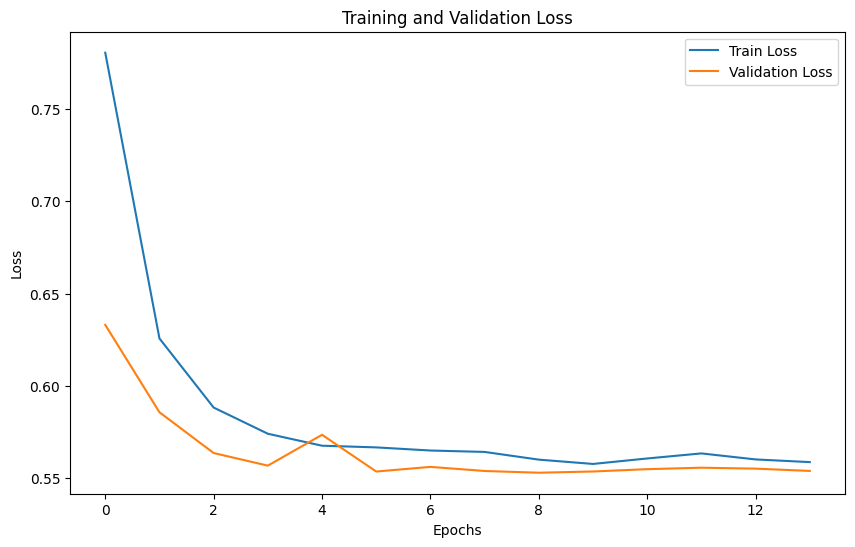

In [15]:
# Initialize model
input_size = 1000
model = SpectralLineClassifier(input_size=input_size)

# Train the model
train_model(model, train_loader, val_loader, device)

##Testing

Test model with signals batch

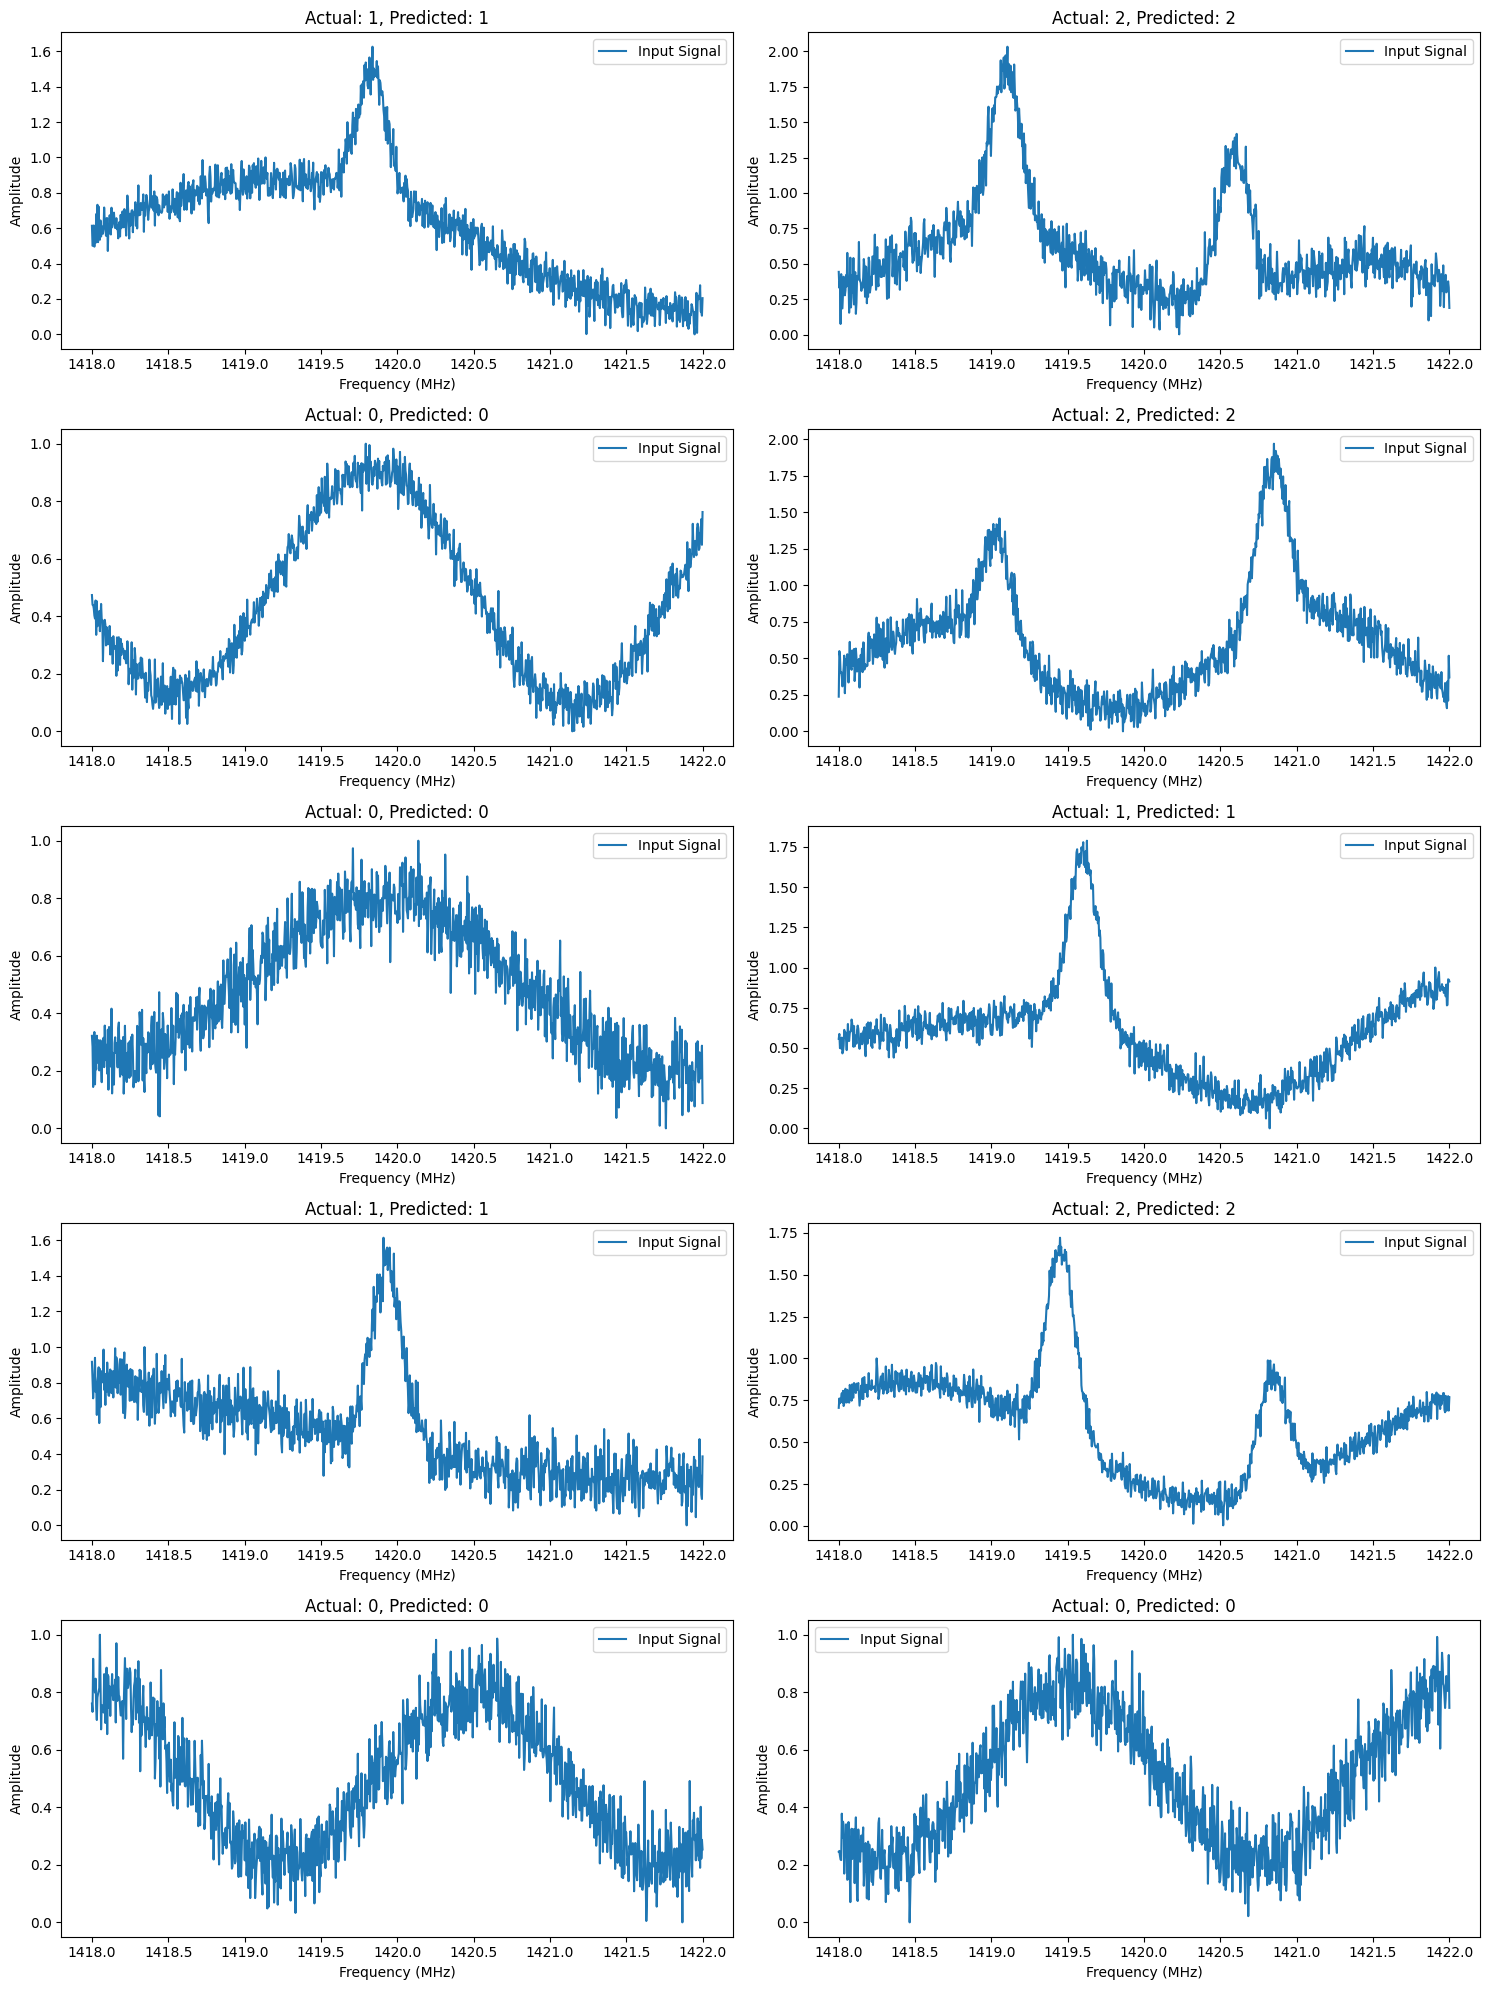

Test Accuracy: 99.80%


In [16]:
n_samples = 1000
freq_range = np.linspace(1418, 1422, n_samples)

test_model(model, val_loader, freq_range, device)

Test model with one signal

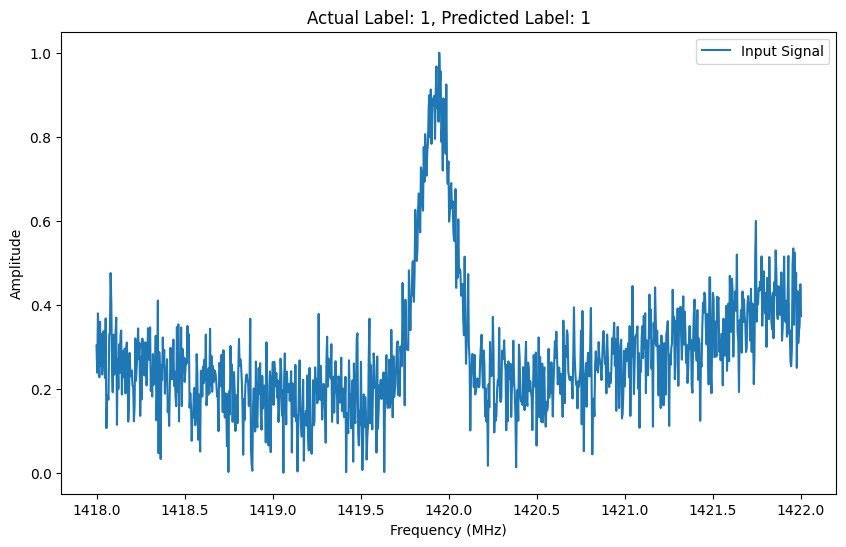

Actual Label: 1
Predicted Label: 1


In [17]:
n_samples = 1000
freq_range = np.linspace(1418, 1422, n_samples)

test_model_with_single_signal(model, n_samples, freq_range, device)